### Batery Drainage Prediction

In this notebook we are going to do a Regression Task for predicting battery drainage using the dataset obtained on kaggle:

https://www.kaggle.com/code/anmatngu/predicting-battery-drain-in-mobile-devices/input


### Imports

In the following code cell we are going to import all the packages that will be used in this notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings 
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from helperfns.tables import tabulate_data

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

numpy:  1.26.4
pandas:  2.1.4


### Seed

In the following code cell we are going to set the `SEED` for reproducivity in this notebook.

In [3]:
SEED = 7

np.random.seed(SEED)
random.seed(SEED)

Next we are going to read our data from a `csv` file to a pandas dataframe.

In [5]:
dataframe = pd.read_csv("user_behavior_dataset.csv")
dataframe.head(3)

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2


We are going to remove two columns, which are `User Id` and `Device Model` from the above dataframe and we rename our column names to have abbriviations that are lower cased.

In [7]:
dataframe = dataframe.iloc[:,2:]
columns = {
    "Operating System": 'os',
    "App Usage Time (min/day)": 'aut',
    "Screen On Time (hours/day)": 'sot',
    "Battery Drain (mAh/day)": 'bd',
    "Number of Apps Installed": 'nai', 
    "Data Usage (MB/day)": 'du',
    "User Behavior Class": "ubc", "Age": 'age', 'Gender': 'gender'
}
dataframe.rename(columns=columns, inplace=True)
dataframe.head(2)

,os,aut,sot,bd,nai,du,age,gender,ubc
0,Android,393,6.4,1872,67,1122,40,Male,4
1,Android,268,4.7,1331,42,944,47,Female,3


### Data Visualization and Insights.

In this section we are going to do data analyisis, using plots so that we can see how the data is distributed in our dataset and have a better understanding of our data.

In the following code cell we are going to visualize how the `Screen on Time (hours/day)` between `gender` using different `os` phones. 

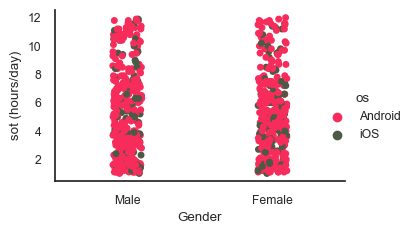

In [11]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
ax = sns.catplot(data=dataframe, hue="os", x="gender", y="sot", palette=['#F72C5B', '#4B5945'])
ax.set(xlabel="Gender", ylabel="sot (hours/day)")
ax.fig.set_figwidth(4)
ax.fig.set_figheight(2)

From the above plot, we can see that both male and female that are using android and ios phones, spend different hours using their phones.


In the following code cell we are going to check how many `male` and `female` phone users are using `android` and `ios`, for that we are going to use the `countplot`.

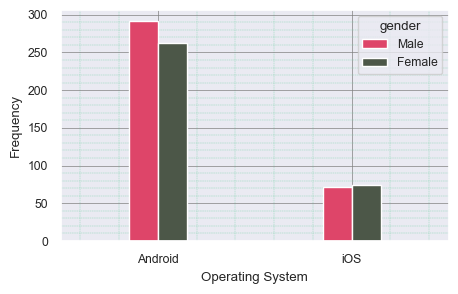

In [13]:
sns.set(font_scale=.8)
fig, ax = plt.subplots(figsize=(5, 3))
sns.countplot(x="os", hue="gender", data=dataframe, palette=['#F72C5B', '#4B5945'], width=.3, ax=ax)
ax.set(xlabel="Operating System", ylabel="Frequency")

plt.minorticks_on()
sns.set(rc={"axes.facecolor":"#FFFFFF","figure.facecolor":"#FFFFFF"})
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

In the following code cell we are going to check the propotion of people relative to the `Battery Drain (mAh/day)` between males and females.

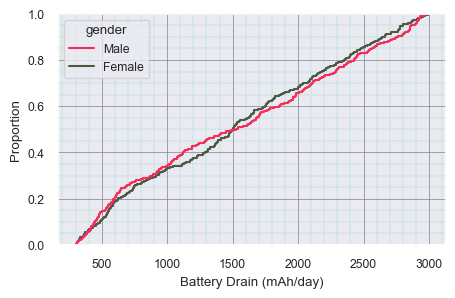

In [33]:
sns.set(font_scale=.8)
fig, ax = plt.subplots(figsize=(5, 3))
sns.ecdfplot(data=dataframe, hue="gender", x="bd", palette=['#F72C5B', '#4B5945'],ax=ax)
ax.set(xlabel="Battery Drain (mAh/day)")
plt.minorticks_on()
sns.set(rc={"axes.facecolor":"#FFFFFF","figure.facecolor":"#FFFFFF"})
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

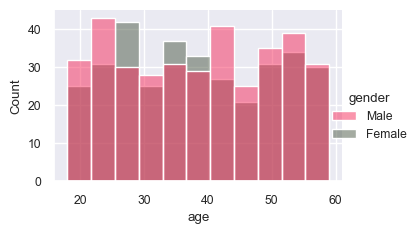

In [86]:
sns.set(font_scale=.8)
ax = sns.displot(data=dataframe, x="age", hue="gender", ax=ax, palette=['#F72C5B', '#4B5945'])
sns.set( rc={"axes.facecolor":"#FFFFFF","figure.facecolor":"#FFFFFF"})
ax.fig.set_figwidth(4)
ax.fig.set_figheight(2)

In the following code cell we are going to check the density of batery drainage between gender, to detemine which gender uses phone more and has the main battery drainage. For that we are going to use the `kdeplot` to show this relationship.

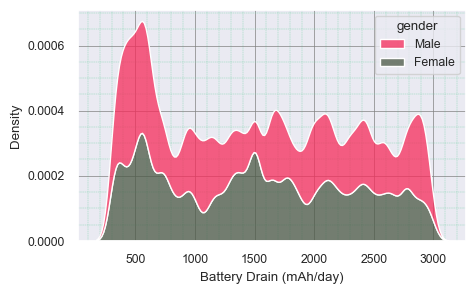

In [49]:
sns.set(font_scale=.8)
fig, ax = plt.subplots(figsize=(5, 3))
sns.kdeplot(data=dataframe,  x="bd", hue="gender", bw_adjust=.2, multiple="stack", fill=True, palette=['#F72C5B', '#4B5945'],ax=ax)
ax.set(xlabel="Battery Drain (mAh/day)")
plt.minorticks_on()
sns.set(rc={"axes.facecolor":"#FFFFFF","figure.facecolor":"#FFFFFF"})
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

From the above plot, it is shown that more males has high battery drainage than females.

In the following code cell we are going to check the relationship of `os` and  `age` using the `displot`.

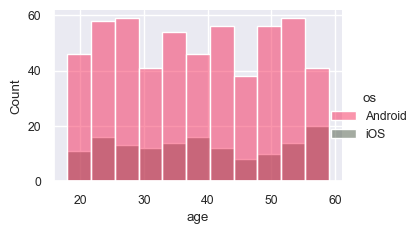

In [92]:
sns.set(font_scale=.8)
ax = sns.displot(data=dataframe, x="age", hue="os", ax=ax, palette=['#F72C5B', '#4B5945'])
sns.set( rc={"axes.facecolor":"#FFFFFF","figure.facecolor":"#FFFFFF"})
ax.fig.set_figwidth(4)
ax.fig.set_figheight(2)

From the above plot, it can be seen that more users are using `android` phones in all age groups.

In the next code cell we are going to check the relationship between data usage and gender using the `displot`.

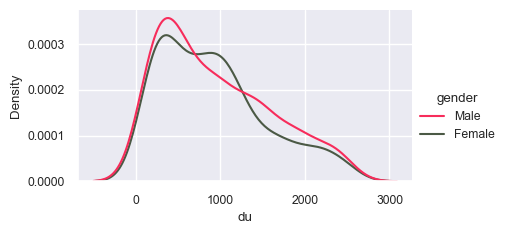

In [99]:
sns.set(font_scale=.8)
ax = sns.displot(data=dataframe, x="du", hue="gender", ax=ax, palette=['#F72C5B', '#4B5945'], kind='kde')
sns.set( rc={"axes.facecolor":"#FFFFFF","figure.facecolor":"#FFFFFF"})
ax.fig.set_figwidth(5)
ax.fig.set_figheight(2)

### Feture processing.

In this section we are going to process the features. We are going to start by getting all the features and target values.

In [101]:
X = dataframe.drop(columns=['bd'])
y = dataframe['bd'].values

Then we will then split our data into 2 sets which are:

1. `train`
2. `test`

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=.2)
X_train.shape, y_train.shape

((560, 8), (560,))

In the following code cell we are going to visualize the examples in each set.

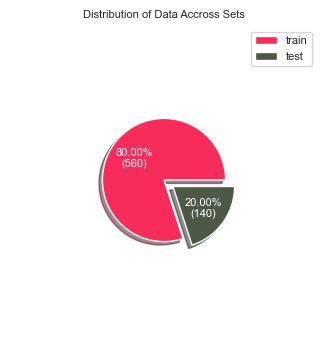

In [106]:
dist_sets = {'train': len(y_train), 'test': len(y_test)}
def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)
colors = ['#F72C5B', '#4B5945']
plt.figure(figsize=(4, 4))
plt.title("Distribution of Data Accross Sets", fontsize=8)
plt.pie(
    dist_sets.values(), labels=dist_sets.keys(), autopct=lambda x: fmt(x, len(y)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .09],
    colors=colors, shadow=True,
)
plt.legend(fontsize=8)
plt.show()

Our dataset is not that big, we only have `700` examples. In the following code cell we are going to get the numerical and none numerical columns from the dataset so that we can start the scaling of numerical features.

In [108]:
categorical_columns = ['os', 'gender']
numerical_columns = [col for col in X_train.columns if col not in categorical_columns]

numerical_columns, categorical_columns

(['aut', 'sot', 'nai', 'du', 'age', 'ubc'], ['os', 'gender'])

For all the numerical column, we are going to use the `StandardScaler` and for the  none numerical columns we are going to start by using the `Ordinal` scaler to convert them to numbers and then we scale them using the `StandardScaler`.

> In our column tranformer we are going to fit the entire dataset. 

In [111]:
scale_pipeline = Pipeline([
  ('standard_scaler', StandardScaler())
])
encoder_and_scale_pipeline = scale_pipeline = Pipeline([
  ('odinal_encoder', OrdinalEncoder()),
  ('standard_scaler', StandardScaler())
])

ct = ColumnTransformer([
        ("numerical pre-processing", scale_pipeline, numerical_columns),
        ("categorical pre-processing", encoder_and_scale_pipeline, categorical_columns),
])

ct.fit_transform(X)

train_features_transformed = ct.transform(X_train)
test_features_transformed = ct.transform(X_test)

In the following code cell we are then going to check the first `2` transformed features from the train data after they have been transformed.

In [114]:
train_features_transformed[:2]

array([[-0.14816855, -0.21194504,  0.05121355,  0.23326335, -1.53968224,
         0.00714044, -0.51335943, -1.040833  ],
       [ 0.15436745,  0.25397273,  0.20776151, -0.27350149,  1.54253835,
         0.00714044, -0.51335943, -1.040833  ]])

### Model Selection

In the following code cell we are going to train `5` Regression Algorithm so that we can see which one will perform better among:

1. `Linear Regression (LR)`
2. `Decision Tree Regressor (DTR)`
3. `Random Forest Regressor (RFR)`
4. `Support Vector Regressor (SVR)`
5. `K-Neighbors Regressor (KNR)`

In [117]:
pipeline_lr = Pipeline([('lr_regressor', LinearRegression())])
pipeline_dt = Pipeline([ ('dt_regressor', DecisionTreeRegressor())])
pipeline_rf = Pipeline([('rf_regressor', RandomForestRegressor())])
pipeline_svr = Pipeline([('sv_regressor', SVR())])
pipeline_knn = Pipeline([('knn_regressor', KNeighborsRegressor())])

pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svr, pipeline_knn]
pipe_dict = {0: 'LR', 1: 'DTR', 2: 'RFR', 3: "SVR", 4: 'KNR'}
for pipe in pipelines:
    pipe.fit(train_features_transformed, y_train)

Now that we have trained our algorithms, we want to evaluate them using the test dataset to see the model that will perform better than others. For evaluation of models we are going to use the following metrics:

1. `Root Mean Squared Error (rmse)`
2. `Mean Squared Error (mse)`
3. `Mean Absolute Error (mae)`
4. `Root Squared or coefficient of determination (r2_score)`


In [119]:
scores = []
for i, model in enumerate(pipelines):
    y_pred = model.predict(test_features_transformed)
    mae = mean_absolute_error(y_test, y_pred)
    mse =  mean_squared_error(y_test, y_pred)
    rscore = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    score = {
        'mae': mae, 'mse': mse, 'rmse': rmse, 'r2-score': rscore, 'regressor': pipe_dict[i]
    }
    scores.append(score)

In [122]:
scores_df = pd.DataFrame(scores)
scores_df

,mae,mse,rmse,r2-score,regressor
0,144.660752,29651.666413,172.196592,0.955030,LR
1,213.757143,66553.114286,257.978903,0.899066,DTR
2,147.105714,31320.648830,176.976408,0.952499,RFR
3,633.484397,550134.739809,741.710685,0.165667,SVR
4,157.692857,35917.236857,189.518434,0.945528,KNR


Next we are going to scale our metrics using the `MinMaxScaler` so that they can be plotted on the same axis with a minimum value of `0` and maximum value of `1`

In [125]:
def scale_scores(x):
    return score_scale_pipeline.fit_transform(x.values.reshape(-1, 1)).squeeze()

In [127]:
score_scale_pipeline = MinMaxScaler()
scores_df['mae'] = scale_scores(scores_df['mae'])
scores_df['mse'] = scale_scores(scores_df['mse'])
scores_df['rmse'] = scale_scores(scores_df['rmse'])
scores_df['r2-score'] = scale_scores(scores_df['r2-score'])
scores_df.head()

,mae,mse,rmse,r2-score,regressor
0,0.000000,0.000000,0.000000,1.000000,LR
1,0.141352,0.070898,0.150624,0.929102,DTR
2,0.005002,0.003207,0.008393,0.996793,RFR
3,1.000000,1.000000,1.000000,0.000000,SVR
4,0.026660,0.012038,0.030415,0.987962,KNR


In the following code cell we are going to plot the metrics obtained by each algorithm after they have been scaled using `MinMaxScaler`.

> The reason why we scaled these metrics using `MinMaxScaler` was to allow all the values to be between `0` and `1` so that they can be visibly plotted on the same axis.

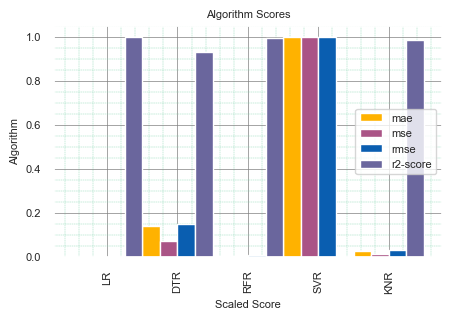

In [150]:
scores_df.plot(
    x='regressor', kind='bar', stacked=False, figsize=(5, 3), fontsize=8,
    color=['#FFB200', '#AA5486', '#0A5EB0', '#6A669D'],
    width=1
)
plt.minorticks_on()
sns.set(rc={"axes.facecolor":"#FFFFFF","figure.facecolor":"#FFFFFF"})
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.legend(loc=7, fontsize=8)
plt.xlabel('Scaled Score', fontsize=8)
plt.ylabel('Algorithm', fontsize=8)
plt.title('Algorithm Scores', fontsize=8)
plt.show()

### Best Model

From the above plot it is observed that the `LR` algorithm performs better than others, the Algorithm obtained `r2` (Root Squared or coefficient of determination) of `1` indicating that the `LR` algorithm found the best fit for the data.

Next we are going to use the `GridSearchCV` to find the best parameters which are the best for this model.

In [152]:
parameters = {'fit_intercept':[True, False], 'n_jobs':[None, 0, 1, 2] }
regressor = LinearRegression()
gs = GridSearchCV(regressor, parameters)
gs.fit(train_features_transformed, y_train)

GridSearchCV(estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'n_jobs': [None, 0, 1, 2]})

Next we are going to train our model using the best parameters for this task found using the `GridSearchCV`

In [155]:
gs.best_params_

{'fit_intercept': True, 'n_jobs': None}

In [157]:
regressor = LinearRegression(**gs.best_params_)
regressor.fit(train_features_transformed, y_train)

LinearRegression()

### Regressor Evaluation

In the following code cell we are going to evaluate our regressor based on the test dataset.

In [160]:
y_pred = regressor.predict(test_features_transformed)
mae = mean_absolute_error(y_test, y_pred)
mse =  mean_squared_error(y_test, y_pred)
rscore = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

score = {
    'mae': mae, 'mse': mse, 'rmse': rmse, 'r2-score': rscore
}

In the following code cell we are going to make some display the metric scores based on the test dataset, for the `Linear Regression` algorithm.

In [163]:
data = []
for k, v in score.items():
    data.append([k, f"{v:,.2f}"])
tabulate_data(column_names=['metric', 'score'], data=data, title="Linear Regression Metrics")

Linear Regression Metrics
+----------+-----------+
| metric   |     score |
+----------+-----------+
| mae      |    144.66 |
| mse      | 29,651.67 |
| rmse     |    172.20 |
| r2-score |      0.96 |
+----------+-----------+


### Predictions.

Predicting `Battery Drain (mAh/day)`

In [166]:
test_dataframe =  X_test.reset_index(drop=True)
test_dataframe['bd'] = y_test
test_dataframe['pred_bd'] = y_pred
test_dataframe.head(10)

,os,aut,sot,nai,du,age,gender,ubc,bd,pred_bd
0,Android,512,10.5,82,1694,41,Male,5,2538,2687.130870
1,iOS,121,3.2,34,596,39,Male,2,651,965.123699
2,Android,201,5.0,59,709,24,Male,3,1482,1545.032165
3,Android,497,9.7,94,2076,18,Male,5,2876,2700.492920
4,Android,524,8.9,88,1730,20,Female,5,2549,2672.447947
5,Android,539,8.4,89,2415,26,Male,5,2796,2686.562626
6,Android,37,1.4,18,295,19,Female,1,369,393.222173
7,Android,104,2.9,35,322,30,Male,2,653,965.923136
8,Android,534,10.8,90,1538,37,Male,5,2805,2716.603357
9,Android,405,7.3,75,1162,37,Female,4,2082,2106.132881


In the following code cell we are going to plot the predicted `'Battery Drain (mAh/day)'` with the actual values on the same axis using a line graph for the first `50` features.

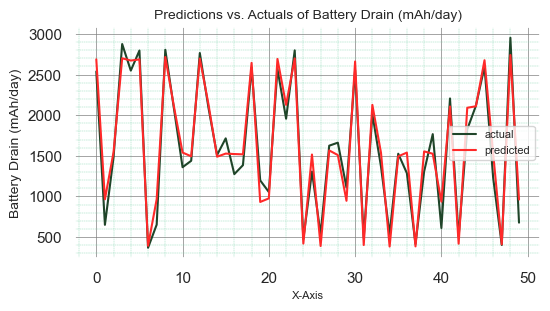

In [171]:
plt.figure(figsize=(6, 3))
plt.plot(y_test[:50], label='actual', color="#1F4529")
plt.plot(y_pred[:50], label='predicted', color="#FF2929")
plt.xlabel('X-Axis', fontsize=8)
plt.ylabel('Battery Drain (mAh/day)', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Predictions vs. Actuals of Battery Drain (mAh/day)", fontsize=10)
plt.show()
